In [89]:
'''1、导入数据集'''
from itertools import count
import skimage.io as io
import numpy as np

''' 导入训练样本'''
file = "./data/train/*.jpg"
coll = io.ImageCollection(file)
# 500样本 ， 前250🐱 ，后250🐶
X_train = np.asarray(coll)
# 输出标签 ， 前面250个为🐱，输出为1 ， 后250个为🐶，输出为0
y_train = np.hstack((np.ones(250),np.zeros(250)))

'''导入测试样本'''
file = "./data/test/*.jpg"
coll = io.ImageCollection(file)
# 200样本， 前100🐱 ，后100🐶
X_test = np.asarray(coll)
#输出标签 ， 前面100个为🐱，输出为1 ， 后100个为🐶，输出为0
y_test = np.hstack((np.ones(100),np.zeros(100)))

m_train = X_train.shape[0]
m_test = X_test.shape[0]
w, h, d = X_train.shape[1],X_train.shape[2],X_train.shape[3]

print('训练样本数量：%d' % m_train)
print('测试样本数量：%d' % m_test)
print('每张图片的维度：(%d, %d, %d)' % (w, h, d)) # w,h,d 表示图片维度，64，64，3 其中3表示rbg 三个值
# print(X_train)



训练样本数量：500
测试样本数量：200
每张图片的维度：(64, 64, 3)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


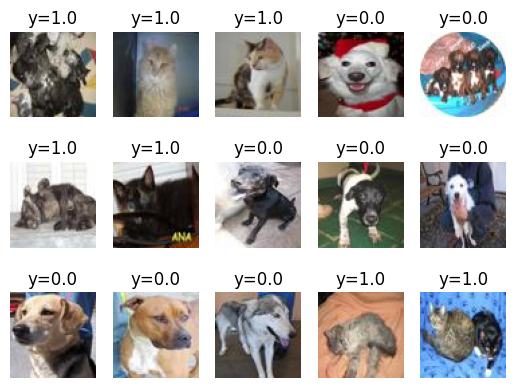

In [90]:
'''简单测试一下是修猫还是修够'''
import matplotlib.pyplot as plt

idx = [np.random.choice(m_train) for _ in range(15)]    #随机选出10张图片
# print(idx)
label = y_train[idx]    #给出图片所对应的标签
# print(label)
for i in range(3):
    for j in range(5):
        print(5*i+j)
        plt.subplot(3,5,5*i+j+1)
        plt.imshow(X_train[idx[5*i+j]])
        plt.title("y="+str(label[5*i+j]))
        plt.axis('off')
plt.show()  

In [91]:
'''数据预处理'''
#这里的X_train.reshape(m_train,-1) 表示将X_train的维度设置为 行数 为 m_train，固定行数后可推断出来 列数
X_train = X_train.reshape(m_train,-1).T
X_test = X_test.reshape(m_test,-1).T

print('训练样本维度：' + str(X_train.shape))
print('测试样本维度：' + str(X_test.shape))

#图片像素归一化至 [0,1]
X_train = X_train / 255
X_test = X_test / 255

训练样本维度：(12288, 500)
测试样本维度：(12288, 200)


In [92]:
'''初始化参数 w 和 b'''
def init_parameters(layer_dims):
    parameters = {}     #存储参数w 和 b
    L = len(layer_dims) #神经网络的层数，包含输入层

    for l in range(1,L):
        parameters['W'+str(l)] = np.random.randn(layer_dims[l],layer_dims[l-1])*0.1
        parameters['b'+str(l)] = np.zeros((layer_dims[l],1))
    
    return parameters

In [93]:
'''正向传播（前向运算）单层神经元'''
# sigmoid 函数
def sigmoid(Z):
    A = 1/(1+np.exp(-Z))
    return A

# reLu 函数
def reLu(Z):
    A = np.maximum(0,Z)
    return A

# 单个神经元运算单元
def linear_activation_forward(A_prev,W,b,activation):

    Z = np.dot(W,A_prev) + b  #线性输出
    if activation == 'sigmoid':
        A = sigmoid(Z)
    elif activation == 'reLu':
        A = reLu(Z)
    
    cache = (A_prev,W,b,Z)

    return A,cache    

In [94]:
'''正向传播（前向运算） L层神经元
   前 l-1 层用reLu函数，最后一层用sigmoid函数
'''
def model_forward(X,parameters):

    caches = []
    A = X
    L = len(parameters) // 2  #这里是因为parameters是含有所有层神经网络的W和b参数，因此除以2就是神经网络的层数

    # 前 L-1 层使用 reLu 函数
    for l in range(1,L):
        A_prev = A     #此处A_prev 表示前一个神经网络
        A,cache = linear_activation_forward(A_prev,parameters['W'+str(l)],parameters['b'+str(l)],"reLu")
        caches.append(cache)

    # L 层使用 Sigmoid
    AL,cache = linear_activation_forward(A,parameters['W'+str(L)],parameters['b'+str(L)],'sigmoid')
    caches.append(cache)
    return AL,caches

损失函数如下：
$$J=-\frac{1}{m}\sum_{i=1}^my^{(i)}log\hat y^{(i)}+(1-y^{(i)})log(1-\hat
y^{(i)})$$

In [95]:
'''损失函数'''
# 输入第 L 层输出和 真实值
def compute_cost(AL,Y):
    
    m = AL.shape[1]     #m 为样本个数，1行 m 个
    cost = -1/m * np.sum(Y*np.log(AL)+(1-Y)*np.log(1-AL))

    cost = np.squeeze(cost)     # 压缩维度，减少[]

    return cost

单层神经网络中的 $dZ^{[l]}$，$dW^{[l]}$，$db^{[l]}$，$dA^{[l-1]}$ ，前 L-1 层为reLu，第L层为 sigmoid
$$dZ^{[l]}=dA^{[l]}*g^{[l]'}(Z^{[l]})$$

$$dW^{[l]}=\frac1mdZ^{[l]}\cdot A^{[l-1]T}$$

$$db^{[l]}=\frac1mnp.sum(dZ^{l]},axis=1)$$

$$dA^{[l-1]}=W^{[l]T}\cdot dZ^{[l]}$$

In [96]:
'''反向传播，减少损失函数'''
# reLu求倒数
'''这里 第Z层的reLu'''
def reLu_backward(dA,Z):
    dZ = np.array(dA,copy=True)
    dZ[Z <= 0] = 0
    
    return dZ

# sigmoid求导数
def sigmoid_backward(dA,Z):
    a = 1/(1+np.exp(-Z))
    dZ = dA * a*(1 - a)

    return dZ

In [97]:
'''单层神经元的反向传播'''
def linear_activation_backward(dA,cache,activation):

    A_prev,W,b,Z = cache

    if activation == 'reLu':
        dZ = reLu_backward(dA,Z)
    elif activation == 'sigmoid':
        dZ = sigmoid_backward(dA,Z)
    
    m = dA.shape[1]
    dW = 1/m * np.dot(dZ ,A_prev.T)
    db = 1/m * np.sum(dZ,axis = 1,keepdims=True)
    dA_prev = np.dot(W.T , dZ)

    return dA_prev,dW,db

    

反向传播 L 层神经网络：
$$dZ^{[l]}=dA^{[l]}*g^{[l]'}(Z^{[l]})$$

$$dW^{[l]}=\frac1mdZ^{[l]}\cdot A^{[l-1]T}$$

$$db^{[l]}=\frac1mnp.sum(dZ^{l]},axis=1)$$

$$dA^{[l-1]}=W^{[l]T}\cdot dZ^{[l]}$$

前 L-1 层为reLu，第L层为 sigmoid ，最后一层输出为 AL

AL的值 J 对 AL 求偏导，其中 :
$$L=-[ylog\hat y+(1-y)log(1-\hat y)]$$

In [115]:
def model_backward(AL,Y,caches):

    grads = {}
    L = len(caches)     #神经网络的层数
    m = AL.shape[1]     #样本个数
    Y = Y.reshape(AL.shape)  #保证Y与AL的维度一致

    # AL的值 J 对AL求偏导,AL就是输出值，而Y就是真实值，就是计算 Y 与 AL之间的关系 记住！ 反向传播都是在对损失函数做优化，这里是用交叉熵做的，看清楚！
    dAL = -(np.divide(Y,AL) - np.divide(1-Y,1-AL))

    # 第L层，激活函数是 sigmoid
    current_cache = caches[L-1]   # 第L个cache
    grads["dA"+str(L-1)],grads["dW"+str(L)],grads["db"+str(L)] = linear_activation_backward(dAL,current_cache,activation="sigmoid")

    # 前 L-1 层，激活函数是 reLu
    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp,dW_temp,db_temp = linear_activation_backward(grads["dA"+str(l+1)],current_cache,activation='reLu')
        grads['dA'+str(l)] = dA_prev_temp
        grads['dW'+str(l+1)] = dW_temp
        grads['db'+str(l+1)] = db_temp

    return grads

更新 w 和 b:
$$W^{[1]}=W^{[1]}-\eta\cdot dW^{[1]}$$

$$b^{[1]}=b^{[1]}-\eta\cdot db^{[1]}$$

$$W^{[2]}=W^{[2]}-\eta\cdot dW^{[2]}$$

$$b^{[2]}=b^{[2]}-\eta\cdot db^{[2]}$$

其中，$\eta$ 是学习因子。

In [99]:
'''更新 W 和 b 参数'''
def update_parameters(parameters,grads,learning_rate):
    L = len(parameters) // 2 # 神经网络的层数

    for l in range(L):
        parameters['W'+str(l+1)] -= learning_rate*grads['dW'+str(l+1)]
        parameters['b'+str(l+1)] -= learning_rate*grads['db'+str(l+1)]

    return parameters

In [100]:
'''整个model的代码'''

def dnn_model(X,Y,layers_dims,learning_rate = 0.01,num_iteration = 3000,print_cost = False):
    np.random.seed(1)
    costs = []

    #参数初始化
    parameters = init_parameters(layers_dims)

    #迭代训练
    for i in range(0,num_iteration):
        # 正向传播
        AL,caches = model_forward(X,parameters)
        # 计算损失函数
        cost = compute_cost(AL,Y)
        # 反向传播
        grads = model_backward(AL,Y,caches)
        # 更新参数
        parameters = update_parameters(parameters,grads,learning_rate)
        # 没次迭代100次，打印 cost
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
    
    # 绘制 cost 趋势图
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundred)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()

    return parameters


In [101]:
'''模型预测'''

def predict(X,y,parameters):

    m = X.shape[1]
    p = np.zeros((1,m))

    #正向传播
    AL,caches = model_forward(X,parameters)
    predictions = AL > 0.5

    accuracy = np.mean(predictions == y)

    print("Accuracy: %f" % accuracy)
    
    return predictions

In [113]:
'''训练模型'''
layers_dims = [12288,10,1]
parameters = dnn_model(X_train,y_train,layers_dims,learning_rate=0.01,num_iteration=6000,print_cost=True)

Cost after iteration 0: 0.934763


KeyboardInterrupt: 

In [ ]:
'''测试训练样本准确率'''
pred_train = predict(X_train,y_train,parameters)

Accuracy: 1.000000


In [ ]:
'''测试样本准确率'''
pred_test = predict(X_test,y_test,parameters)

Accuracy: 0.585000


Cost after iteration 0: 0.693276
Cost after iteration 100: 0.692989
Cost after iteration 200: 0.692644
Cost after iteration 300: 0.692065
Cost after iteration 400: 0.690771
Cost after iteration 500: 0.687637
Cost after iteration 600: 0.678452
Cost after iteration 700: 0.650180
Cost after iteration 800: 0.637638
Cost after iteration 900: 0.630431
Cost after iteration 1000: 0.574506
Cost after iteration 1100: 0.444934
Cost after iteration 1200: 0.326400
Cost after iteration 1300: 0.213594
Cost after iteration 1400: 0.109814
Cost after iteration 1500: 0.069903
Cost after iteration 1600: 0.871253
Cost after iteration 1700: 0.709458
Cost after iteration 1800: 0.612780
Cost after iteration 1900: 0.618345
Cost after iteration 2000: 0.347897
Cost after iteration 2100: 0.013503
Cost after iteration 2200: 0.003185
Cost after iteration 2300: 0.001828
Cost after iteration 2400: 0.001273
Cost after iteration 2500: 0.000970
Cost after iteration 2600: 0.000778
Cost after iteration 2700: 0.000646
Cost

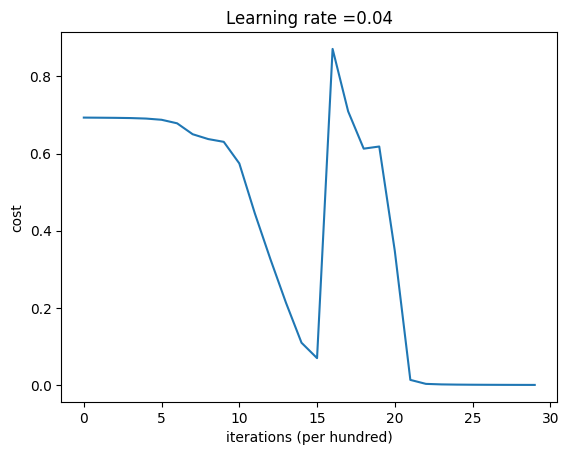

In [117]:
'''将原来的2层模型上升至5层 每层神经元个数为12288 100 50 10 4 1'''
layers_dims = [12288,100,50,10,4,1]
parameters = dnn_model(X_train,y_train,layers_dims,learning_rate=0.04,num_iteration=3000,print_cost=True)

In [118]:
'''测试训练样本准确率'''
pred_train = predict(X_train,y_train,parameters)

Accuracy: 1.000000


In [120]:
'''测试样本准确率'''
pred_test = predict(X_test,y_test,parameters)

Accuracy: 0.605000
